# Reading data

In [1]:
import numpy as np
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy.misc import imsave
from resizeimage import resizeimage
from PIL import Image

# from objectives.VoObjectives import rmse, vo_loss
from models.AbstractModel import AbstractModel
from dataset.DataGenerationStrategy import OpticalFlowGenerationStrategy
from dataset.Sequence import Sequence
import robot as rb


Robotics Toolbox for Python
Based on Matlab Toolbox Version 7  April-2002

What's new.
  Readme      - New features and enhancements in this version.

Homogeneous transformations
  eul2tr      - Euler angle to transform 
  oa2tr       - orientation and approach vector to transform 
  rotx        - transform for rotation about X-axis 
  roty        - transform for rotation about Y-axis 
  rotz        - transform for rotation about Z-axis 
  rpy2tr      - roll/pitch/yaw angles to transform 
  tr2eul      - transform to Euler angles 
  tr2rot      - transform to rotation submatrix
  tr2rpy      - transform to roll/pitch/yaw angles
  transl      - set or extract the translational component of a transform 
  trnorm      - normalize a transform 
  
Quaternions
  /           - divide quaternion by quaternion or scalar
  *           - multiply quaternion by a quaternion or vector
  inv         - invert a quaternion 
  norm        - norm of a quaternion 
  plot        - display a quaternion as

Using TensorFlow backend.


In [2]:
data_set_dir = 'D:/KITTI/dataset/'

kitti_train_dirs = ['00', '01', '02', '03', '04', '05', '06', '07']
kitti_test_dirs = ['08', '09', '10']

input_width = 155
input_height = 47

#input_width = 310
#input_height = 94

input_channel = 1
kitti_is_grayscale = True

training_seqs = OrderedDict()
test_seqs = OrderedDict()

name = 'kitti'

In [3]:
def read_data():

        subdir = 'disparity'

        
        for dir in kitti_train_dirs:
            seq_dir = os.path.normpath(os.path.join(data_set_dir, subdir, dir))
            training_seqs[dir] = Sequence(seq_dir,
                                               extension='png',
                                               label_file=os.path.join(seq_dir, dir  + '.txt'),
                                               dir=dir,
                                               is_grayscale=kitti_is_grayscale,
                                               name='Kitti_train/' + dir)

        for dir in kitti_test_dirs:
            seq_dir = os.path.normpath(os.path.join(data_set_dir, subdir, dir))
            print(dir)
            
            print(os.path.join(seq_dir, subdir))
            test_seqs[dir] = Sequence(seq_dir,
                                           extension='png',
                                           label_file=os.path.join(seq_dir, dir  + '.txt'),
                                           dir=dir,
                                           is_grayscale=kitti_is_grayscale,
                                           name='Kitti_test/' + dir)
            
def print_info():

        print('--------------------------')
        print('------Dataset Info--------')
        print('Dataset Name: {}'.format(name))
        print('Number of Training dirs: {}'.format(len(training_seqs)))
        print('Training dirs:')
        for directory in training_seqs:
            curr_sequence = training_seqs[directory]
            print(directory,
                  curr_sequence.sequence_dir,
                  'Num imgs: {}'.format(curr_sequence.get_num_imgs()),
                  'Num label: {}'.format(curr_sequence.get_num_label()))

        print('Number of Test dirs: {}'.format(len(test_seqs)))
        print('Test dirs:')
        for directory in test_seqs:
            curr_sequence = test_seqs[directory]
            print(directory,
                  curr_sequence.sequence_dir,
                  'Num imgs: {}'.format(curr_sequence.get_num_imgs()),
    'Num label: {}'.format(curr_sequence.get_num_label()))        

In [4]:
read_data()
print_info()

08
D:\KITTI\dataset\disparity\08\disparity
09
D:\KITTI\dataset\disparity\09\disparity
10
D:\KITTI\dataset\disparity\10\disparity
--------------------------
------Dataset Info--------
Dataset Name: kitti
Number of Training dirs: 8
Training dirs:
00 D:\KITTI\dataset\disparity\00 Num imgs: 4541 Num label: 4541
01 D:\KITTI\dataset\disparity\01 Num imgs: 1101 Num label: 1101
02 D:\KITTI\dataset\disparity\02 Num imgs: 4661 Num label: 4661
03 D:\KITTI\dataset\disparity\03 Num imgs: 801 Num label: 801
04 D:\KITTI\dataset\disparity\04 Num imgs: 271 Num label: 271
05 D:\KITTI\dataset\disparity\05 Num imgs: 2761 Num label: 2761
06 D:\KITTI\dataset\disparity\06 Num imgs: 1101 Num label: 1101
07 D:\KITTI\dataset\disparity\07 Num imgs: 1101 Num label: 1101
Number of Test dirs: 3
Test dirs:
08 D:\KITTI\dataset\disparity\08 Num imgs: 4071 Num label: 4071
09 D:\KITTI\dataset\disparity\09 Num imgs: 1591 Num label: 1591
10 D:\KITTI\dataset\disparity\10 Num imgs: 1201 Num label: 1201


## Read and transform training pose

In [5]:
cont = 0
label_training_all = {}
for directory in training_seqs:    
    curr_sequence = training_seqs[directory]
    labels = curr_sequence.get_labels()
    name = curr_sequence.get_dir()
    label_aux = []
    
    for label in labels:
        matrix = np.reshape(label, (3, 4))
        homogeneous = np.array([[0, 0, 0, 1]])
        matrix = np.vstack((matrix, homogeneous))   
        
        t_aux = matrix[0:3, 3]        
        t = np.zeros((1,3))
        
        for i in range(0,3):
            t[0, i] = t_aux[i]
            cont += 1
            
        rpy = rb.tr2rpy(matrix)
        label_aux.append(np.concatenate((rpy, t),1))
        
    label_training_all[name] = label_aux[1:]

print(len(label_training_all))
print(set(label_training_all))

8
{'00', '04', '06', '07', '02', '03', '01', '05'}


In [6]:
for element in label_training_all:
    print("Size of sequence %s: %s"%(element, len(label_training_all[element])))

Size of sequence 07: 1100
Size of sequence 04: 270
Size of sequence 02: 4660
Size of sequence 03: 800
Size of sequence 06: 1100
Size of sequence 00: 4540
Size of sequence 01: 1100
Size of sequence 05: 2760


## Read and normalize training images 

In [7]:
dataset_training_all_l = {}
dataset_training_all_r = {}

for directory in training_seqs:
    curr_sequence = training_seqs[directory]
    paths = curr_sequence.get_image_paths()
    name = curr_sequence.get_dir()
    num_images = curr_sequence.get_num_imgs()
    img_aux = []
    cont = 0
    print("Sequence: ", name)    
    for path in paths:
        img = Image.open(path)        
        img = img.resize((input_width, input_height))
        
        img_new = np.array(img.getdata()).reshape(img.size[1], img.size[0])
        img_new = img_new / 255.0        
        img_aux.append(img_new)
        
        del(img_new)
        del(img)

        print("%s \r"%cont, end="", flush=True)    
        cont += 1
        
    print("List length: ", len(img_aux))
    print("Right list length: ", len(img_aux[1:]))
    print("Left list length: ", len(img_aux[:-1]))
    print("")
    
    dataset_training_all_r[name] = img_aux[1:]
    dataset_training_all_l[name] = img_aux[:-1]
    
    del(img_aux)
    

Sequence:  00
List length:  4541
Right list length:  4540
Left list length:  4540

Sequence:  01
List length:  1101
Right list length:  1100
Left list length:  1100

Sequence:  02
List length:  4661
Right list length:  4660
Left list length:  4660

Sequence:  03
List length:  801
Right list length:  800
Left list length:  800

Sequence:  04
List length:  271
Right list length:  270
Left list length:  270

Sequence:  05
List length:  2761
Right list length:  2760
Left list length:  2760

Sequence:  06
List length:  1101
Right list length:  1100
Left list length:  1100

Sequence:  07
List length:  1101
Right list length:  1100
Left list length:  1100



In [8]:
print("Training right: ")
print(len(dataset_training_all_r))
print(set(dataset_training_all_r))

for element in dataset_training_all_r:
    img = dataset_training_all_r[element][0]
    print("Sequence %s: Size = %s and dim = %s."%(element, len(dataset_training_all_r[element]), 
                                                  np.shape(img)))
    imsave("%s.jpg"%element, img.reshape(input_height, input_width))
    
print(" ")
print("Training left: ")

print(len(dataset_training_all_l))
print(set(dataset_training_all_l))

for element in dataset_training_all_l:
    img = dataset_training_all_l[element][0]
    print("Sequence %s: Size = %s and dim = %s."%(element, len(dataset_training_all_l[element]), 
                                                  np.shape(img)))
    imsave("%s.jpg"%element, img.reshape(input_height, input_width))

Training right: 
8
{'00', '04', '06', '07', '02', '03', '01', '05'}
Sequence 07: Size = 1100 and dim = (47, 155).
Sequence 04: Size = 270 and dim = (47, 155).
Sequence 02: Size = 4660 and dim = (47, 155).
Sequence 03: Size = 800 and dim = (47, 155).
Sequence 06: Size = 1100 and dim = (47, 155).
Sequence 00: Size = 4540 and dim = (47, 155).
Sequence 01: Size = 1100 and dim = (47, 155).
Sequence 05: Size = 2760 and dim = (47, 155).
 
Training left: 
8
{'00', '04', '06', '07', '02', '03', '01', '05'}
Sequence 07: Size = 1100 and dim = (47, 155).
Sequence 04: Size = 270 and dim = (47, 155).
Sequence 02: Size = 4660 and dim = (47, 155).
Sequence 03: Size = 800 and dim = (47, 155).
Sequence 06: Size = 1100 and dim = (47, 155).
Sequence 00: Size = 4540 and dim = (47, 155).
Sequence 01: Size = 1100 and dim = (47, 155).
Sequence 05: Size = 2760 and dim = (47, 155).


## Read and test pose

In [9]:
cont = 0
label_test_all = {}
for directory in test_seqs:    
    curr_sequence = test_seqs[directory]
    labels = curr_sequence.get_labels()
    name = curr_sequence.get_dir()
    label_aux = []
    
    for label in labels:
        matrix = np.reshape(label, (3, 4))
        homogeneous = np.array([[0, 0, 0, 1]])
        matrix = np.vstack((matrix, homogeneous))   
        
        t_aux = matrix[0:3, 3]        
        t = np.zeros((1,3))
        
        for i in range(0,3):
            t[0, i] = t_aux[i]
            cont += 1
            
        rpy = rb.tr2rpy(matrix)
        label_aux.append(np.concatenate((rpy, t),1))
        
    label_test_all[name] = label_aux[1:]

print(len(label_test_all))
print(set(label_test_all))

3
{'10', '09', '08'}


In [10]:
for element in label_test_all:
    print("Size of sequence %s: %s"%(element, len(label_test_all[element])))

Size of sequence 10: 1200
Size of sequence 09: 1590
Size of sequence 08: 4070


## Read and normalize test images 

In [11]:
dataset_test_all_r = {}
dataset_test_all_l = {}

for directory in test_seqs:
    curr_sequence = test_seqs[directory]
    paths = curr_sequence.get_image_paths()
    name = curr_sequence.get_dir()
    num_images = curr_sequence.get_num_imgs()
    img_aux = []
    cont = 0
    print("Sequence: ", name)
    
    for path in paths:
        img = Image.open(path)        
        img = img.resize((input_width, input_height))
        
        img_new = np.array(img.getdata()).reshape(img.size[1], img.size[0])
        img_new = img_new / 255.0        
        img_aux.append(img_new)
        
        del(img_new)
        del(img)
        percentage = round((cont/num_images)*100,2)
        
        print("%s \r"%cont, end="", flush=True)    
        cont += 1
        
    print("List length: ", len(img_aux))
    print("Right list length: ", len(img_aux[1:]))
    print("Left list length: ", len(img_aux[:-1]))
    print("")
    
    dataset_test_all_r[name] = img_aux[1:]
    dataset_test_all_l[name] = img_aux[:-1]
    
    del(img_aux)
    

Sequence:  08
List length:  4071
Right list length:  4070
Left list length:  4070

Sequence:  09
List length:  1591
Right list length:  1590
Left list length:  1590

Sequence:  10
List length:  1201
Right list length:  1200
Left list length:  1200



In [12]:
print("Test right: ")
print(len(dataset_test_all_r))
print(set(dataset_test_all_r))

for element in dataset_test_all_r:
    img = dataset_test_all_r[element][0]
    print("Sequence %s: Size = %s and dim = %s."%(element, len(dataset_test_all_r[element]), np.shape(img)))
    imsave("%s.jpg"%element, img.reshape(input_height, input_width))
          
print(" ")
print("Test left: ")

print(len(dataset_test_all_l))
print(set(dataset_test_all_l))

for element in dataset_test_all_l:
    img = dataset_test_all_l[element][0]
    print("Sequence %s: Size = %s and dim = %s."%(element, len(dataset_test_all_l[element]), np.shape(img)))
    imsave("%s.jpg"%element, img.reshape(input_height, input_width))

Test right: 
3
{'10', '09', '08'}
Sequence 10: Size = 1200 and dim = (47, 155).
Sequence 09: Size = 1590 and dim = (47, 155).
Sequence 08: Size = 4070 and dim = (47, 155).
 
Test left: 
3
{'10', '09', '08'}
Sequence 10: Size = 1200 and dim = (47, 155).
Sequence 09: Size = 1590 and dim = (47, 155).
Sequence 08: Size = 4070 and dim = (47, 155).


In [13]:
training_r = []
training_l = []
training_poses = []

test_r = []
test_l = []
test_poses = []

for sequence in kitti_train_dirs:
    
    for img in dataset_training_all_r[sequence]:
        training_r.append(img)        
    for img in dataset_training_all_l[sequence]:
        training_l.append(img)   
    for pose in label_training_all[sequence]:
        training_poses.append(pose)

print("Training > size right: %s, size left: %s, size label: %s"%
      (len(training_r), len(training_l), len(training_poses)))

print(" ")

for sequence in kitti_test_dirs:    
        for img in dataset_test_all_r[sequence]:
            test_r.append(img)        
        for img in dataset_test_all_l[sequence]:
            test_l.append(img)   
        for pose in label_test_all[sequence]:
            test_poses.append(pose)
            
print("Test > Size right: %s, size left: %s, size label: %s"%
      (len(test_r), len(test_l), len(test_poses)))

print(" ")


Training > size right: 16330, size left: 16330, size label: 16330
 
Test > Size right: 6860, size left: 6860, size label: 6860
 


### Preparando a entrada para o padrão Tensorflow

In [14]:
training_r = np.reshape(training_r, (len(training_r), input_height, input_width, 1))
training_l = np.reshape(training_l, (len(training_l), input_height, input_width, 1))

print(np.shape(training_r))

test_r = np.reshape(test_r, (len(test_r), input_height, input_width, 1))
test_l = np.reshape(test_l, (len(test_l), input_height, input_width, 1))
print(np.shape(test_r))

(16330, 47, 155, 1)
(6860, 47, 155, 1)


# 6DOF Ground Truth

In [15]:
cont = 0
label_training_0 = {}
label_training_1 = {}

for directory in training_seqs:    
    curr_sequence = training_seqs[directory]
    labels = curr_sequence.get_labels()
    name = curr_sequence.get_dir()
    label_aux = []
    
    for label in labels:
        matrix = np.reshape(label, (3, 4))
        homogeneous = np.array([[0, 0, 0, 1]])
        matrix = np.vstack((matrix, homogeneous))   
        label_aux.append(matrix)
        
    label_training_0[name] = label_aux[:-1]
    label_training_1[name] = label_aux[1:]


In [16]:
T_train = {}

for directory in training_seqs:    
    curr_sequence = training_seqs[directory]
    name = curr_sequence.get_dir()
    T_aux = []
    
    for pose_0, pose_1 in zip(label_training_0[name], label_training_1[name]):
        transformation = pose_0.dot(np.linalg.inv(pose_1))
        t_aux = transformation[0:3, 3]        
        t = np.zeros((1,3))
        
        for i in range(0,3):
            t[0, i] = t_aux[i]
            cont += 1
            
        rpy = rb.tr2rpy(transformation)
        
        T_aux.append(np.concatenate((rpy, t),1))
    
        T_train[name] = T_aux    

In [17]:
training_poses_transformed = []

for sequence in kitti_train_dirs:
  
    for pose in T_train[sequence]:
        training_poses_transformed.append(pose)

print("Training > size right: %s, size left: %s, size label: %s"%
      (len(training_r), len(training_l), len(training_poses)))

Training > size right: 16330, size left: 16330, size label: 16330


In [18]:
cont = 0
label_test_0 = {}
label_test_1 = {}

for directory in test_seqs:    
    curr_sequence = test_seqs[directory]
    labels = curr_sequence.get_labels()
    name = curr_sequence.get_dir()
    label_aux = []
    
    for label in labels:
        matrix = np.reshape(label, (3, 4))
        homogeneous = np.array([[0, 0, 0, 1]])
        matrix = np.vstack((matrix, homogeneous))
        label_aux.append(matrix)
        
        
    label_test_0[name] = label_aux[:-1]
    label_test_1[name] = label_aux[1:]


In [19]:
T_test = {}

for directory in test_seqs:    
    curr_sequence = test_seqs[directory]
    name = curr_sequence.get_dir()
    T_aux = []
    
    for pose_0, pose_1 in zip(label_test_0[name], label_test_1[name]):
        transformation = pose_0.dot(np.linalg.inv(pose_1))
        t_aux = transformation[0:3, 3]        
        t = np.zeros((1,3))
        
        for i in range(0,3):
            t[0, i] = t_aux[i]
            cont += 1
            
        rpy = rb.tr2rpy(transformation)
        
        T_aux.append(np.concatenate((rpy, t),1))
    
    T_test[name] = T_aux

In [20]:
test_poses_transformed = []

for sequence in kitti_test_dirs:    
        for pose in T_test[sequence]:
            test_poses_transformed.append(pose)
    
print("Test > Size right: %s, size left: %s, size label: %s"%
      (len(test_r), len(test_l), len(test_poses)))

Test > Size right: 6860, size left: 6860, size label: 6860


In [21]:
y_training = np.reshape(training_poses_transformed, (len(training_poses), 6))
y_test = np.reshape(test_poses_transformed, (len(test_poses), 6))
print(np.shape(y_training))

(16330, 6)


# Thesis ground Truth

## Read and transform training pose (of thesis)

In [15]:
cont = 0
label_training_thesis_0 = {}
label_training_thesis_1 = {}

for directory in training_seqs:    
    curr_sequence = training_seqs[directory]
    labels = curr_sequence.get_labels()
    name = curr_sequence.get_dir()
    label_aux = []
    
    for label in labels:
        matrix = np.reshape(label, (3, 4))
        homogeneous = np.array([[0, 0, 0, 1]])
        matrix = np.vstack((matrix, homogeneous))   

        label_aux.append(matrix)
        
        
    label_training_thesis_0[name] = label_aux[:-1]
    label_training_thesis_1[name] = label_aux[1:]


## Transformation

In [16]:
from math import asin, atan2, sqrt

T_train_thesis = {}

for directory in training_seqs:    
    curr_sequence = training_seqs[directory]
    name = curr_sequence.get_dir()
    T_aux = []
    
    for pose_0, pose_1 in zip(label_training_thesis_0[name], label_training_thesis_1[name]):
        
        Tx = pose_1[0][3]
        Tz = pose_1[2][3]
        Tx_ant = pose_0[0][3]
        Tz_ant = pose_0[2][3]

        Ri_1 = pose_1[0][0]
        Ri_3 = pose_1[0][2]    
        Ri_1_ant = pose_0[0][0]
        Ri_3_ant = pose_0[0][2]
        
        Ti = [Tx, Tz]
        Ti_ant = [Tx_ant, Tz_ant]

        displacement = sqrt(sum([(a - b) ** 2 for a, b in zip(Ti, Ti_ant)]))
        delta_Theta = atan2(Ri_3, Ri_1) - atan2(Ri_3_ant, Ri_1_ant)
    
        T_aux.append([delta_Theta, displacement])
    
    T_train_thesis[name] = T_aux
    print(len(T_train_thesis[name]))
    

4540
1100
4660
800
270
2760
1100
1100


## Read and transform test pose (of thesis)

In [17]:
cont = 0
label_test_thesis_0 = {}
label_test_thesis_1 = {}

for directory in test_seqs:    
    curr_sequence = test_seqs[directory]
    labels = curr_sequence.get_labels()
    name = curr_sequence.get_dir()
    label_aux = []
    
    for label in labels:
        matrix = np.reshape(label, (3, 4))
        homogeneous = np.array([[0, 0, 0, 1]])
        matrix = np.vstack((matrix, homogeneous))   

        label_aux.append(matrix)
        
        
    label_test_thesis_0[name] = label_aux[:-1]
    label_test_thesis_1[name] = label_aux[1:]


## Transformation

In [18]:
T_test_thesis = {}

for directory in test_seqs:    
    curr_sequence = test_seqs[directory]
    name = curr_sequence.get_dir()
    T_aux = []
    
    for pose_0, pose_1 in zip(label_test_thesis_0[name], label_test_thesis_1[name]):
        
        Tx = pose_1[0][3]
        Tz = pose_1[2][3]
        Tx_last = pose_0[0][3]
        Tz_last = pose_0[2][3]

        Ri_1 = pose_1[0][0]
        Ri_3 = pose_1[0][2]    
        Ri_1_last = pose_0[0][0]
        Ri_3_last = pose_0[0][2]
        
        Ti = [Tx, Tz]
        Ti_last = [Tx_last, Tz_last]

        displacement = sqrt(sum([(a - b) ** 2 for a, b in zip(Ti, Ti_last)]))
        delta_Theta = atan2(Ri_3, Ri_1) - atan2(Ri_3_last, Ri_1_last)
    
        T_aux.append([delta_Theta, displacement])
    
    T_test_thesis[name] = T_aux
    # print(T_train)
    

In [19]:
training_poses_transformed_thesis = []

for sequence in kitti_train_dirs:
  
    for pose in T_train_thesis[sequence]:
        training_poses_transformed_thesis.append(pose)

In [20]:
test_poses_transformed_thesis = []

for sequence in kitti_test_dirs:    
        for pose in T_test_thesis[sequence]:
            test_poses_transformed_thesis.append(pose)
            

### Preparando a entrada para o padrão Tensorflow

In [21]:
y_training = np.reshape(training_poses_transformed_thesis, (len(training_poses_transformed_thesis), 2))
y_test = np.reshape(test_poses_transformed_thesis, (len(test_poses_transformed_thesis), 2))
print(np.shape(y_training))

(16330, 2)


In [23]:
import pandas as pd

y_training_hacked = np.zeros((len(y_training), 2))
y_training_hacked[:,0] = y_training[:,0]*950
y_training_hacked[:,1] = y_training[:,1]

y_test_hacked = np.zeros((len(y_test), 2))
y_test_hacked[:,0] = y_test[:,0]*950
y_test_hacked[:,1] = y_test[:,1]

train_df = pd.DataFrame(y_training_hacked)
test_df = pd.DataFrame(y_test_hacked)

train_df.describe()

,0,1
count,16330.000000,16330.000000
mean,-0.020984,0.000355
std,2.719510,0.017553
min,-18.706326,-0.074321
25%,-1.369062,-0.002612
50%,-0.016105,0.000084
75%,1.346503,0.002380
max,18.200720,0.083055


In [24]:
test_df.describe()

,0,1
count,6860.000000,6860.000000
mean,-0.015727,-0.002335
std,2.688253,0.016444
min,-14.007403,-0.068335
25%,-1.403611,-0.004597
50%,-0.056893,-0.000072
75%,1.384160,0.002578
max,24.702216,0.058259


# Expanding network size

## Definindo a arquitetura
***

### Definindo os valores de beta:

In [22]:
beta_list = []

beta_list.append(950)
#beta_aux = 150

#while(beta_aux <= 2000):    
#    beta_list.append(beta_aux)
    
#    beta_aux += 200
    
print(beta_list)

[950]


## Change loss function

In [23]:
from objectives.VoObjectives import vo_loss, rmse

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, MaxPooling2D, merge, Conv2D, add, concatenate, LeakyReLU
from keras.layers.core import Activation, Flatten
from keras.optimizers import RMSprop
from keras.optimizers import SGD, Adam, Adadelta
from keras import backend as K
from keras import optimizers as optm
from keras import losses
from keras.callbacks import TensorBoard, ModelCheckpoint

flag_6_outputs = True
flag_3_outputs = False

learning_rate = 0.0001
epochs = 200

def get_abs_diff(vects):
    x, y = vects
    return K.abs(x - y)

def abs_diff_output_shape(shapes):
    shape1, shape2 = shapes
    return shape1

def create_cnn_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''

    seq = Sequential()
    seq.add(Conv2D(64, (3, 3), input_shape=input_dim))
    seq.add(Activation('relu'))
    #seq.add(MaxPooling2D(pool_size=(2, 2)))

    seq.add(Conv2D(64, (3, 3)))
    seq.add(Activation('relu'))
    #seq.add(MaxPooling2D(pool_size=(2, 2)))

    seq.add(Conv2D(64, (3, 3)))
    seq.add(Activation('relu'))
    #seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    seq.add(Conv2D(128, (3, 3)))
    seq.add(Activation('relu'))
    #seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    seq.add(Conv2D(128, (3, 3)))
    seq.add(Activation('relu'))
    #seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    seq.add(Conv2D(128, (3, 3)))
    seq.add(Activation('relu'))
    #seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    seq.add(Conv2D(256, (3, 3)))
    seq.add(Activation('relu'))
    #seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    seq.add(Conv2D(256, (3, 3)))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    seq.add(Conv2D(256, (3, 3)))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))

    seq.add(Flatten())
    #seq.add(Dense(1028))
    #seq.add(Activation('relu'))
    # seq.add(Dropout(0.5))
    # seq.add(Dense(32))

    return seq

input_shape = (input_height, input_width, 1)
base_network = create_cnn_network(input_shape)

input_a = Input(input_shape)
input_b = Input(input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

abs_diff = Lambda(get_abs_diff, output_shape=abs_diff_output_shape)([processed_a, processed_b])
dense_layer = Dense(64)(abs_diff)
#activation1 = LeakyReLU(alpha=0.5)(dense_layer)
#dense_layer1 = Dense(64)(activation1)
activation2 = LeakyReLU(alpha=0.2)(dense_layer)
dense_layer1 = Dense(32)(activation2)
activation3 = LeakyReLU(alpha=0.1)(dense_layer1)
    
if(flag_6_outputs):
    output = Dense(6, name='predictions')(activation3)
    
elif(flag_3_outputs):
    output = Dense(2, name='predictions')(activation3)

model = Model([input_a, input_b], output)

learning_rate = 0.00001

### Preparando os checkpoints

In [36]:
cont = 0

In [37]:
beta =  beta_list[cont]
cont += 1

learning_rate = 0.0001

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate)
#mean_squared_error
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[rmse, 'acc'])
# model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

BETA igual a 950.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50688)        1918848     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50688)        0           sequential_1[1][0]        

### Beta 7

In [38]:

#beta =  beta_list[cont]
#cont += 1

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

#opt = optm.Adam(lr=learning_rate)
#model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
#model.summary()

model_path = "D:/KITTI/Graph/DepthVO-6DOF/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/DepthVO-6DOF/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=25, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 950.
Train on 16330 samples, validate on 6860 samples
Epoch 1/25
16330/16330 [==============================] - 309s 19ms/step - loss: 13.7241 - rmse: 3.1445 - acc: 0.2453 - val_loss: 6.6910 - val_rmse: 1.7196 - val_acc: 0.2840

Epoch 00001: val_loss improved from inf to 6.69098, saving model to D:/KITTI/Graph/DepthVO-6DOF/model/950/weights.best.hdf5

Epoch 00001: acc improved from -inf to 0.24532, saving model to D:/KITTI/Graph/DepthVO-6DOF/model/950/weights.best.by.accuracy.hdf5
Epoch 2/25
16330/16330 [==============================] - 309s 19ms/step - loss: 9.3922 - rmse: 2.7566 - acc: 0.3287 - val_loss: 6.2116 - val_rmse: 1.6799 - val_acc: 0.3239

Epoch 00002: val_loss improved from 6.69098 to 6.21159, saving model to D:/KITTI/Graph/DepthVO-6DOF/model/950/weights.best.hdf5

Epoch 00002: acc improved from 0.24532 to 0.32866, saving model to D:/KITTI/Graph/DepthVO-6DOF/model/950/weights.best.by.accuracy.hdf5
Epoch 3/25
16330/16330 [==============================] - 308s 

16330/16330 [==============================] - 306s 19ms/step - loss: 0.6252 - rmse: 0.7584 - acc: 0.6257 - val_loss: 6.8932 - val_rmse: 1.7844 - val_acc: 0.3480

Epoch 00023: val_loss did not improve from 6.21159

Epoch 00023: acc improved from 0.61310 to 0.62566, saving model to D:/KITTI/Graph/DepthVO-6DOF/model/950/weights.best.by.accuracy.hdf5
Epoch 24/25
16330/16330 [==============================] - 306s 19ms/step - loss: 0.5747 - rmse: 0.7275 - acc: 0.6287 - val_loss: 7.2087 - val_rmse: 1.8397 - val_acc: 0.3424

Epoch 00024: val_loss did not improve from 6.21159

Epoch 00024: acc improved from 0.62566 to 0.62866, saving model to D:/KITTI/Graph/DepthVO-6DOF/model/950/weights.best.by.accuracy.hdf5
Epoch 25/25
16330/16330 [==============================] - 307s 19ms/step - loss: 0.5412 - rmse: 0.7037 - acc: 0.6412 - val_loss: 7.3224 - val_rmse: 1.8546 - val_acc: 0.3455

Epoch 00025: val_loss did not improve from 6.21159

Epoch 00025: acc improved from 0.62866 to 0.64115, saving mod

### Beta 8

In [26]:

beta =  beta_list[cont]
cont += 1

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate)
model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=25, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 350.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50688)        1918848     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50688)        0           sequential_1[1][0]        

### Beta 9

In [27]:

beta =  beta_list[cont]
cont += 1

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate)
model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=25, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 550.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50688)        1918848     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50688)        0           sequential_1[1][0]        

16330/16330 [==============================] - 305s 19ms/step - loss: 0.2896 - rmse: 0.0660 - acc: 0.9991 - val_loss: 1.0588 - val_rmse: 0.1688 - val_acc: 0.9991

Epoch 00020: val_loss did not improve from 1.02836

Epoch 00020: acc did not improve from 0.99957
Epoch 21/25
16330/16330 [==============================] - 305s 19ms/step - loss: 0.3033 - rmse: 0.0739 - acc: 0.9990 - val_loss: 1.0710 - val_rmse: 0.1709 - val_acc: 0.9991

Epoch 00021: val_loss did not improve from 1.02836

Epoch 00021: acc did not improve from 0.99957
Epoch 22/25
16330/16330 [==============================] - 305s 19ms/step - loss: 0.2850 - rmse: 0.0658 - acc: 0.9996 - val_loss: 1.0534 - val_rmse: 0.1729 - val_acc: 0.9991

Epoch 00022: val_loss did not improve from 1.02836

Epoch 00022: acc did not improve from 0.99957
Epoch 23/25
16330/16330 [==============================] - 305s 19ms/step - loss: 0.2802 - rmse: 0.0673 - acc: 0.9993 - val_loss: 1.1134 - val_rmse: 0.1664 - val_acc: 0.9990

Epoch 00023: val_l

### Beta 10

In [28]:

beta =  beta_list[cont]

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate)
model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=25, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 750.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50688)        1918848     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50688)        0           sequential_1[1][0]        

16330/16330 [==============================] - 305s 19ms/step - loss: 0.2411 - rmse: 0.0662 - acc: 0.9996 - val_loss: 1.1771 - val_rmse: 0.1560 - val_acc: 0.9991

Epoch 00020: val_loss improved from 1.18377 to 1.17714, saving model to D:/KITTI/Graph/DepthVOExpanded_Beta/model/750/weights.best.hdf5

Epoch 00020: acc did not improve from 0.99976
Epoch 21/25
16330/16330 [==============================] - 305s 19ms/step - loss: 0.2328 - rmse: 0.0652 - acc: 0.9995 - val_loss: 1.3278 - val_rmse: 0.1664 - val_acc: 0.9988

Epoch 00021: val_loss did not improve from 1.17714

Epoch 00021: acc did not improve from 0.99976
Epoch 22/25
16330/16330 [==============================] - 305s 19ms/step - loss: 0.2258 - rmse: 0.0625 - acc: 0.9992 - val_loss: 1.1853 - val_rmse: 0.1583 - val_acc: 0.9991

Epoch 00022: val_loss did not improve from 1.17714

Epoch 00022: acc did not improve from 0.99976
Epoch 23/25
16330/16330 [==============================] - 305s 19ms/step - loss: 0.2461 - rmse: 0.0664 - ac

### Beta 1

In [29]:

beta =  beta_list[cont]
cont += 1

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate)
model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=25, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 950.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50688)        1918848     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50688)        0           sequential_1[1][0]        

### Beta 2

In [30]:

beta =  beta_list[cont]
cont += 1

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate)
model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=25, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 1150.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50688)        1918848     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50688)        0           sequential_1[1][0]       

16330/16330 [==============================] - 306s 19ms/step - loss: 0.5721 - rmse: 0.0945 - acc: 0.9991 - val_loss: 1.5042 - val_rmse: 0.1651 - val_acc: 0.9990

Epoch 00020: val_loss did not improve from 1.38868

Epoch 00020: acc did not improve from 0.99939
Epoch 21/25
16330/16330 [==============================] - 306s 19ms/step - loss: 0.5601 - rmse: 0.1003 - acc: 0.9993 - val_loss: 1.4294 - val_rmse: 0.1505 - val_acc: 0.9991

Epoch 00021: val_loss did not improve from 1.38868

Epoch 00021: acc did not improve from 0.99939
Epoch 22/25
16330/16330 [==============================] - 306s 19ms/step - loss: 0.5586 - rmse: 0.0921 - acc: 0.9994 - val_loss: 1.4614 - val_rmse: 0.1733 - val_acc: 0.9990

Epoch 00022: val_loss did not improve from 1.38868

Epoch 00022: acc did not improve from 0.99939
Epoch 23/25
16330/16330 [==============================] - 306s 19ms/step - loss: 0.5474 - rmse: 0.0961 - acc: 0.9991 - val_loss: 1.4030 - val_rmse: 0.1590 - val_acc: 0.9991

Epoch 00023: val_l

### Beta 3

In [31]:

beta =  beta_list[cont]
cont += 1

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate)
model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=25, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 1350.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50688)        1918848     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50688)        0           sequential_1[1][0]       


Epoch 00019: val_loss did not improve from 1.51807

Epoch 00019: acc did not improve from 0.99951
Epoch 20/25
16330/16330 [==============================] - 306s 19ms/step - loss: 0.4179 - rmse: 0.0941 - acc: 0.9993 - val_loss: 1.5483 - val_rmse: 0.1589 - val_acc: 0.9990

Epoch 00020: val_loss did not improve from 1.51807

Epoch 00020: acc did not improve from 0.99951
Epoch 21/25
16330/16330 [==============================] - 306s 19ms/step - loss: 0.3662 - rmse: 0.0948 - acc: 0.9992 - val_loss: 1.5449 - val_rmse: 0.1560 - val_acc: 0.9990

Epoch 00021: val_loss did not improve from 1.51807

Epoch 00021: acc did not improve from 0.99951
Epoch 22/25
16330/16330 [==============================] - 306s 19ms/step - loss: 0.3694 - rmse: 0.1002 - acc: 0.9996 - val_loss: 1.5403 - val_rmse: 0.1665 - val_acc: 0.9991

Epoch 00022: val_loss did not improve from 1.51807

Epoch 00022: acc improved from 0.99951 to 0.99957, saving model to D:/KITTI/Graph/DepthVOExpanded_Beta/model/1350/weights.best.b

### Beta 4

In [32]:

beta =  beta_list[cont]
cont += 1

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate)
model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=25, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 1550.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50688)        1918848     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50688)        0           sequential_1[1][0]       


Epoch 00018: val_loss did not improve from 1.60249

Epoch 00018: acc did not improve from 0.99969
Epoch 19/25
16330/16330 [==============================] - 306s 19ms/step - loss: 0.2954 - rmse: 0.0812 - acc: 0.9991 - val_loss: 1.6296 - val_rmse: 0.1574 - val_acc: 0.9990

Epoch 00019: val_loss did not improve from 1.60249

Epoch 00019: acc did not improve from 0.99969
Epoch 20/25
16330/16330 [==============================] - 306s 19ms/step - loss: 0.3281 - rmse: 0.0853 - acc: 0.9993 - val_loss: 1.6251 - val_rmse: 0.1534 - val_acc: 0.9991

Epoch 00020: val_loss did not improve from 1.60249

Epoch 00020: acc did not improve from 0.99969
Epoch 21/25
16330/16330 [==============================] - 306s 19ms/step - loss: 0.3163 - rmse: 0.0814 - acc: 0.9994 - val_loss: 1.6064 - val_rmse: 0.1519 - val_acc: 0.9991

Epoch 00021: val_loss did not improve from 1.60249

Epoch 00021: acc did not improve from 0.99969
Epoch 22/25
16330/16330 [==============================] - 306s 19ms/step - loss: 

### Beta 5

In [33]:

beta =  beta_list[cont]
cont += 1

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate)
model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=25, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 1750.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50688)        1918848     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50688)        0           sequential_1[1][0]       

### Beta 6

In [34]:

beta =  beta_list[cont]
cont += 1

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate)
model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=25, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 1950.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50688)        1918848     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50688)        0           sequential_1[1][0]       

16330/16330 [==============================] - 307s 19ms/step - loss: 0.2489 - rmse: 0.0795 - acc: 0.9994 - val_loss: 1.7824 - val_rmse: 0.1539 - val_acc: 0.9990

Epoch 00020: val_loss did not improve from 1.75866

Epoch 00020: acc did not improve from 0.99957
Epoch 21/25
16330/16330 [==============================] - 306s 19ms/step - loss: 0.2188 - rmse: 0.0727 - acc: 0.9994 - val_loss: 1.7812 - val_rmse: 0.1516 - val_acc: 0.9991

Epoch 00021: val_loss did not improve from 1.75866

Epoch 00021: acc did not improve from 0.99957
Epoch 22/25
16330/16330 [==============================] - 307s 19ms/step - loss: 0.1856 - rmse: 0.0672 - acc: 0.9994 - val_loss: 1.7786 - val_rmse: 0.1520 - val_acc: 0.9991

Epoch 00022: val_loss did not improve from 1.75866

Epoch 00022: acc did not improve from 0.99957
Epoch 23/25
16330/16330 [==============================] - 307s 19ms/step - loss: 0.2126 - rmse: 0.0698 - acc: 0.9996 - val_loss: 1.7594 - val_rmse: 0.1503 - val_acc: 0.9990

Epoch 00023: val_l

In [29]:
from math import degrees, sin, cos, pi

## Inferência

### val_loss

In [32]:
for beta in beta_list:
    print("")
    print("Beta igual a %s."%beta)
    print("")
    for sequence in kitti_train_dirs:
        
        print("Sequence %s:"%(sequence))
        cont = 1
        data_training_r = np.array(dataset_training_all_r[sequence])
        data_training_l = np.array(dataset_training_all_l[sequence]) 

        model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
        filepath_model = model_path+str(beta)+"/"+"weights.best.hdf5"
        
        model.load_weights(filepath=filepath_model)    
        prediction = model.predict([data_training_r.reshape((len(data_training_r), input_height, input_width, 1)), 
                                   data_training_l.reshape((len(data_training_l), input_height, input_width, 1))])

        sequence_GT = np.zeros((len(data_training_r)+1, 12))

        init_mat = np.identity(4)
        sequence_GT[0, :] = init_mat[0:3,:].flatten()

        position_X = 0
        position_Z = 0
        angle_total = pi/2

        for element in prediction:
            angle = element[0]
            displacement = element[1]

            angle_total = angle_total - angle

            position_X = position_X + displacement*cos(angle_total)
            position_Z = position_Z + displacement*sin(angle_total)

            sequence_GT[cont, :] = init_mat[0:3,:].flatten()

            sequence_GT[cont, 0] = cos(angle_total-(pi/2))
            sequence_GT[cont, 2] = -sin(angle_total-(pi/2))
            sequence_GT[cont, 3] = position_X
            sequence_GT[cont, 8] = sin(angle_total-(pi/2))
            sequence_GT[cont, 10] = cos(angle_total-(pi/2))
            sequence_GT[cont, 11] = position_Z

            cont += 1
        
        output_path = "D:/KITTI/output_to_draw/DepthVOExpanded_Beta/val_loss/"+str(beta)+"/"
        if not os.path.exists(os.path.dirname(output_path)):
            # print (model_path)
            os.makedirs(os.path.dirname(output_path))
        np.savetxt(output_path+"%s.txt"%(sequence), np.array(sequence_GT), delimiter=" ", fmt='%s')

    for sequence in kitti_test_dirs:
        cont = 1
        print("Sequence %s:"%(sequence))
        data_test_r = np.array(dataset_test_all_r[sequence])
        data_test_l = np.array(dataset_test_all_l[sequence])
        
        model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
        filepath_model = model_path+str(beta)+"/"+"weights.best.hdf5"
        
        prediction = model.predict([data_test_r.reshape((len(data_test_r), input_height, input_width, 1)), 
                                   data_test_l.reshape((len(data_test_l), input_height, input_width, 1))])

        sequence_GT = np.zeros((len(data_test_l)+1, 12))

        init_mat = np.identity(4)
        sequence_GT[0, :] = init_mat[0:3,:].flatten()    

        position_X = 0
        position_Z = 0
        angle_total = pi/2

        for element in prediction:
            angle = element[0]
            displacement = element[1]

            angle_total = angle_total - angle

            position_X = position_X + displacement*cos(angle_total)
            position_Z = position_Z + displacement*sin(angle_total)

            sequence_GT[cont, :] = init_mat[0:3,:].flatten()

            sequence_GT[cont, 0] = cos(angle_total-(pi/2))
            sequence_GT[cont, 2] = -sin(angle_total-(pi/2))
            sequence_GT[cont, 3] = position_X
            sequence_GT[cont, 8] = sin(angle_total-(pi/2))
            sequence_GT[cont, 10] = cos(angle_total-(pi/2))
            sequence_GT[cont, 11] = position_Z

            cont += 1

        output_path = "D:/KITTI/output_to_draw/DepthVOExpanded_Beta/val_loss/"+str(beta)+"/"
        if not os.path.exists(os.path.dirname(output_path)):
            # print (model_path)
            os.makedirs(os.path.dirname(output_path))
        np.savetxt(output_path+"%s.txt"%(sequence), np.array(sequence_GT), delimiter=" ", fmt='%s')


Beta igual a 150.

Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:

Beta igual a 350.

Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:

Beta igual a 550.

Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:

Beta igual a 750.

Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:

Beta igual a 950.

Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:

Beta igual a 1150.

Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:

Beta igual a 1350.



### ACC

In [33]:
for beta in beta_list:
    print("Beta igual a %s."%beta)
    for sequence in kitti_train_dirs:

        print("Sequence %s:"%(sequence))
        cont = 1
        data_training_r = np.array(dataset_training_all_r[sequence])
        data_training_l = np.array(dataset_training_all_l[sequence]) 

        model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
        filepath_model = model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
        
        model.load_weights(filepath=filepath_model)    
        prediction = model.predict([data_training_r.reshape((len(data_training_r), input_height, input_width, 1)), 
                                   data_training_l.reshape((len(data_training_l), input_height, input_width, 1))])

        sequence_GT = np.zeros((len(data_training_r)+1, 12))

        init_mat = np.identity(4)
        sequence_GT[0, :] = init_mat[0:3,:].flatten()

        position_X = 0
        position_Z = 0
        angle_total = pi/2

        for element in prediction:
            angle = element[0]
            displacement = element[1]

            angle_total = angle_total - angle

            position_X = position_X + displacement*cos(angle_total)
            position_Z = position_Z + displacement*sin(angle_total)

            sequence_GT[cont, :] = init_mat[0:3,:].flatten()

            sequence_GT[cont, 0] = cos(angle_total-(pi/2))
            sequence_GT[cont, 2] = -sin(angle_total-(pi/2))
            sequence_GT[cont, 3] = position_X
            sequence_GT[cont, 8] = sin(angle_total-(pi/2))
            sequence_GT[cont, 10] = cos(angle_total-(pi/2))
            sequence_GT[cont, 11] = position_Z

            cont += 1
        
        output_path = "D:/KITTI/output_to_draw/DepthVOExpanded_Beta/acc/"+str(beta)+"/"
        if not os.path.exists(os.path.dirname(output_path)):
            # print (model_path)
            os.makedirs(os.path.dirname(output_path))
        np.savetxt(output_path+"%s.txt"%(sequence), np.array(sequence_GT), delimiter=" ", fmt='%s')

    for sequence in kitti_test_dirs:
        cont = 1
        print("Sequence %s:"%(sequence))
        data_test_r = np.array(dataset_test_all_r[sequence])
        data_test_l = np.array(dataset_test_all_l[sequence])
        
        model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
        filepath_model = model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
        
        prediction = model.predict([data_test_r.reshape((len(data_test_r), input_height, input_width, 1)), 
                                   data_test_l.reshape((len(data_test_l), input_height, input_width, 1))])

        sequence_GT = np.zeros((len(data_test_l)+1, 12))

        init_mat = np.identity(4)
        sequence_GT[0, :] = init_mat[0:3,:].flatten()    

        position_X = 0
        position_Z = 0
        angle_total = pi/2

        for element in prediction:
            angle = element[0]
            displacement = element[1]

            angle_total = angle_total - angle

            position_X = position_X + displacement*cos(angle_total)
            position_Z = position_Z + displacement*sin(angle_total)

            sequence_GT[cont, :] = init_mat[0:3,:].flatten()

            sequence_GT[cont, 0] = cos(angle_total-(pi/2))
            sequence_GT[cont, 2] = -sin(angle_total-(pi/2))
            sequence_GT[cont, 3] = position_X
            sequence_GT[cont, 8] = sin(angle_total-(pi/2))
            sequence_GT[cont, 10] = cos(angle_total-(pi/2))
            sequence_GT[cont, 11] = position_Z

            cont += 1

        output_path = "D:/KITTI/output_to_draw/DepthVOExpanded_Beta/acc/"+str(beta)+"/"
        if not os.path.exists(os.path.dirname(output_path)):
            # print (model_path)
            os.makedirs(os.path.dirname(output_path))
        np.savetxt(output_path+"%s.txt"%(sequence), np.array(sequence_GT), delimiter=" ", fmt='%s')

Beta igual a 150.
Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:
Beta igual a 350.
Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:
Beta igual a 550.
Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:
Beta igual a 750.
Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:
Beta igual a 950.
Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:
Beta igual a 1150.
Sequence 00:
Sequence 01:
Sequence 02:
Sequence 03:
Sequence 04:
Sequence 05:
Sequence 06:
Sequence 07:
Sequence 08:
Sequence 09:
Sequence 10:
Beta igual a 1350.
Sequence 00:
S

In [39]:
a = [x for x in range(-10, 10)]
print(a)

[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [40]:
def relu(x):
    output = []    
    for i in range(0, len(x)):        
        value = x[i]
        if value < 0:
            value = 0
        output.append(value)
    return np.array(output)

def leaky_relu(x, alpha):
    output = []    
    for i in range(0, len(x)):        
        value = x[i]
        if value < 0:
            value = x[i]*alpha
        output.append(value)
    return np.array(output)

relu_values = relu(a)
Leaky_relu_values_1 = leaky_relu(a,0.1)
Leaky_relu_values_2 = leaky_relu(a,0.5)
Leaky_relu_values_3 = leaky_relu(a,1)

In [41]:
print(relu_values)
print("")
print(Leaky_relu_values_1)
print("")
print(Leaky_relu_values_2)
print("")
print(Leaky_relu_values_3)

[0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7 8 9]

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   1.   2.   3.   4.
  5.   6.   7.   8.   9. ]

[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   1.   2.   3.   4.
  5.   6.   7.   8.   9. ]

[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9]


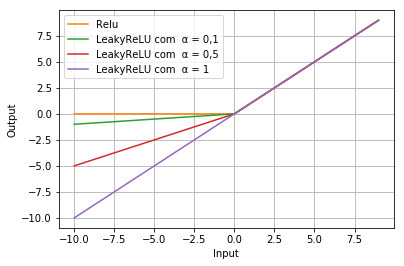

In [43]:
import matplotlib.pyplot as plt
plt.plot(a, relu_values, color='C1', linewidth=1.5, linestyle="-", label="Relu")
plt.plot(a, Leaky_relu_values_1, color='C2', linewidth=1.5, linestyle="-", label="LeakyReLU com  α = 0,1")
plt.plot(a, Leaky_relu_values_2, color='C3', linewidth=1.5, linestyle="-", label="LeakyReLU com  α = 0,5")
plt.plot(a, Leaky_relu_values_3, color='C4', linewidth=1.5, linestyle="-", label="LeakyReLU com  α = 1")

plt.ylabel('Output')
plt.xlabel('Input')
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('leaky-relu-new.png', dpi = 300)

plt.show()

#plt.savefig('leaky-relu-new.png', dpi = 300)


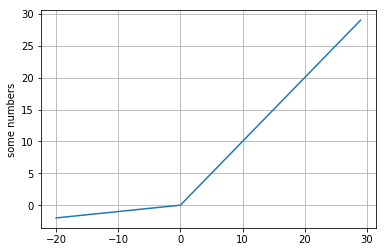

In [41]:
plt.plot(a, Leaky_relu_values_1)
plt.ylabel('some numbers')
plt.grid(True)
plt.show()


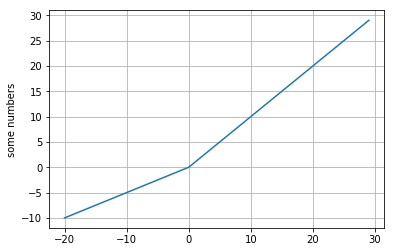

In [42]:
plt.plot(a, Leaky_relu_values_2)
plt.ylabel('some numbers')
plt.grid(True)
plt.show()

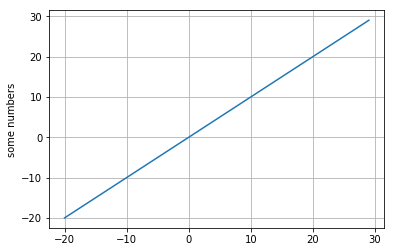

In [43]:
plt.plot(a, Leaky_relu_values_3)
plt.ylabel('some numbers')
plt.grid(True)
plt.show()

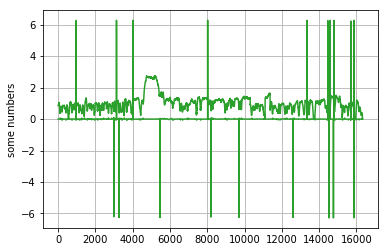

In [30]:
#y_training
#y_test

import matplotlib.pyplot as plt
plt.plot(y_training, color='C2', linewidth=1.5, linestyle="-", label="y_training")
#plt.plot(y_test, color='C1', linewidth=1.5, linestyle="-", label="y_test")

plt.ylabel('some numbers')
plt.grid(True)
plt.show()

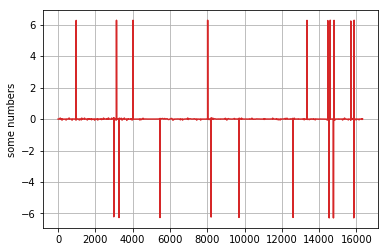

In [34]:
plt.plot(y_training[:,0], color='C3', linewidth=1.5, linestyle="-", label="y_training")

plt.ylabel('some numbers')
plt.grid(True)
plt.show()

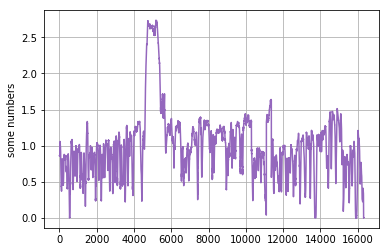

In [35]:
plt.plot(y_training[:,1], color='C4', linewidth=1.5, linestyle="-", label="y_training")

plt.ylabel('some numbers')
plt.grid(True)
plt.show()

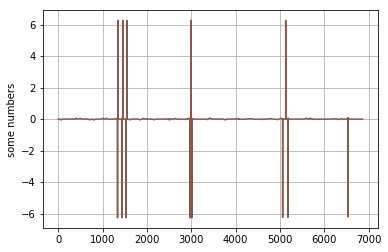

In [36]:
plt.plot(y_test[:,0], color='C5', linewidth=1.5, linestyle="-", label="y_training")

plt.ylabel('some numbers')
plt.grid(True)
plt.show()

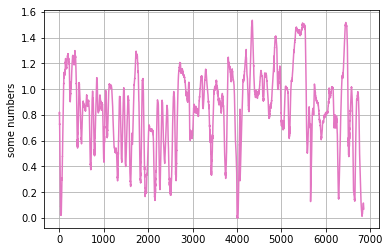

In [37]:
plt.plot(y_test[:,1], color='C6', linewidth=1.5, linestyle="-", label="y_training")

plt.ylabel('some numbers')
plt.grid(True)
plt.show()

# Decay Usage Tests

In [61]:

beta =  beta_list[cont]
cont += 1

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate, decay=0.5)
model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

model_path = "D:/KITTI/Graph/Tests/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/Tests/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=25, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 350.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 50688)        1918848     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 50688)        0           sequential_2[1][0]        


Epoch 00014: val_loss improved from 1.27621 to 1.27583, saving model to D:/KITTI/Graph/Tests/model/350/weights.best.hdf5

Epoch 00014: acc improved from 0.93031 to 0.93307, saving model to D:/KITTI/Graph/Tests/model/350/weights.best.by.accuracy.hdf5
Epoch 15/25
16330/16330 [==============================] - 308s 19ms/step - loss: 1.1756 - rmse: 0.7676 - acc: 0.9351 - val_loss: 1.2755 - val_rmse: 0.6019 - val_acc: 0.9373

Epoch 00015: val_loss improved from 1.27583 to 1.27548, saving model to D:/KITTI/Graph/Tests/model/350/weights.best.hdf5

Epoch 00015: acc improved from 0.93307 to 0.93509, saving model to D:/KITTI/Graph/Tests/model/350/weights.best.by.accuracy.hdf5
Epoch 16/25
16330/16330 [==============================] - 309s 19ms/step - loss: 1.1867 - rmse: 0.7672 - acc: 0.9374 - val_loss: 1.2752 - val_rmse: 0.6017 - val_acc: 0.9394

Epoch 00016: val_loss improved from 1.27548 to 1.27516, saving model to D:/KITTI/Graph/Tests/model/350/weights.best.hdf5

Epoch 00016: acc improved f

In [26]:

#beta =  beta_list[cont]

beta =  950
# cont += 1

def vo_loss_mod_thesis(y_true, y_pred):

    mean = K.square(y_pred - y_true)
    mean_rot = mean[:, 0] * beta
    mean_trasl = mean[:, 1]   
    mean = K.concatenate([mean_rot, mean_trasl])
    sqrt = K.sqrt(K.mean(mean, axis=-1))

    return sqrt

print("BETA igual a %s."%beta)

opt = optm.Adam(lr=learning_rate, decay=0.2)
model.compile(loss=[vo_loss_mod_thesis], optimizer=opt, metrics=[rmse, 'acc'])
model.summary()

model_path = "D:/KITTI/Graph/Tests-decay/model/"
if not os.path.exists(os.path.dirname(model_path)):
        print (model_path)
        os.makedirs(os.path.dirname(model_path))

filepath=model_path+str(beta)+"/"+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

tb_path = "D:/KITTI/Graph/Tests-decay/model/"+str(beta)+"/1/"
tbCallBack = TensorBoard(log_dir=tb_path, histogram_freq=0, write_graph=True, 
                         write_images=True)

filepath2=model_path+str(beta)+"/"+"weights.best.by.accuracy.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, checkpoint2, tbCallBack]

model.fit([training_r, training_l], y_training, batch_size=16, epochs=40, 
                             validation_data=([test_r, test_l], y_test), callbacks=callbacks_list)

BETA igual a 950.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 47, 155, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50688)        1918848     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50688)        0           sequential_1[1][0]        

Epoch 14/40
16330/16330 [==============================] - 319s 20ms/step - loss: 1.4984 - rmse: 0.7513 - acc: 0.9906 - val_loss: 1.7648 - val_rmse: 0.5816 - val_acc: 0.9921

Epoch 00014: val_loss improved from 1.76560 to 1.76475, saving model to D:/KITTI/Graph/Tests-decay/model/950/weights.best.hdf5

Epoch 00014: acc improved from 0.99039 to 0.99063, saving model to D:/KITTI/Graph/Tests-decay/model/950/weights.best.by.accuracy.hdf5
Epoch 15/40
16330/16330 [==============================] - 322s 20ms/step - loss: 1.4975 - rmse: 0.7503 - acc: 0.9913 - val_loss: 1.7640 - val_rmse: 0.5812 - val_acc: 0.9923

Epoch 00015: val_loss improved from 1.76475 to 1.76397, saving model to D:/KITTI/Graph/Tests-decay/model/950/weights.best.hdf5

Epoch 00015: acc improved from 0.99063 to 0.99130, saving model to D:/KITTI/Graph/Tests-decay/model/950/weights.best.by.accuracy.hdf5
Epoch 16/40
16330/16330 [==============================] - 320s 20ms/step - loss: 1.4972 - rmse: 0.7501 - acc: 0.9918 - val_lo

Epoch 33/40
16330/16330 [==============================] - 318s 19ms/step - loss: 1.4911 - rmse: 0.7481 - acc: 0.9947 - val_loss: 1.7559 - val_rmse: 0.5775 - val_acc: 0.9958

Epoch 00033: val_loss improved from 1.75616 to 1.75588, saving model to D:/KITTI/Graph/Tests-decay/model/950/weights.best.hdf5

Epoch 00033: acc improved from 0.99467 to 0.99473, saving model to D:/KITTI/Graph/Tests-decay/model/950/weights.best.by.accuracy.hdf5
Epoch 34/40
16330/16330 [==============================] - 318s 19ms/step - loss: 1.4904 - rmse: 0.7484 - acc: 0.9949 - val_loss: 1.7556 - val_rmse: 0.5774 - val_acc: 0.9959

Epoch 00034: val_loss improved from 1.75588 to 1.75561, saving model to D:/KITTI/Graph/Tests-decay/model/950/weights.best.hdf5

Epoch 00034: acc improved from 0.99473 to 0.99486, saving model to D:/KITTI/Graph/Tests-decay/model/950/weights.best.by.accuracy.hdf5
Epoch 35/40
16330/16330 [==============================] - 318s 19ms/step - loss: 1.4832 - rmse: 0.7477 - acc: 0.9949 - val_lo

In [32]:
beta_list = []
beta_list.append(950)

for beta in beta_list:
    print("")
    print("Beta igual a %s."%beta)
    print("")
    

    for sequence in kitti_test_dirs:
        cont = 1
        print("Sequence %s:"%(sequence))
        data_test_r = np.array(dataset_test_all_r[sequence])
        data_test_l = np.array(dataset_test_all_l[sequence])
        
        model_path = "D:/KITTI/Graph/DepthVOExpanded_Beta/model/"
        filepath_model = model_path+str(beta)+"/"+"weights.best.hdf5"
        
        prediction = model.predict([data_test_r.reshape((len(data_test_r), input_height, input_width, 1)), 
                                   data_test_l.reshape((len(data_test_l), input_height, input_width, 1))])

        sequence_GT = np.zeros((len(data_test_l)+1, 12))

        init_mat = np.identity(4)
        sequence_GT[0, :] = init_mat[0:3,:].flatten()    

        position_X = 0
        position_Z = 0
        angle_total = pi/2

        for element in prediction:
            angle = element[0]
            displacement = element[1]

            angle_total = angle_total - angle

            position_X = position_X + displacement*cos(angle_total)
            position_Z = position_Z + displacement*sin(angle_total)

            sequence_GT[cont, :] = init_mat[0:3,:].flatten()

            sequence_GT[cont, 0] = cos(angle_total-(pi/2))
            sequence_GT[cont, 2] = -sin(angle_total-(pi/2))
            sequence_GT[cont, 3] = position_X
            sequence_GT[cont, 8] = sin(angle_total-(pi/2))
            sequence_GT[cont, 10] = cos(angle_total-(pi/2))
            sequence_GT[cont, 11] = position_Z

            cont += 1

        output_path = "D:/KITTI/output_to_draw/Test_BETA/val_loss/"+str(beta)+"/"
        if not os.path.exists(os.path.dirname(output_path)):
            # print (model_path)
            os.makedirs(os.path.dirname(output_path))
        np.savetxt(output_path+"%s.txt"%(sequence), np.array(sequence_GT), delimiter=" ", fmt='%s')


Beta igual a 950.

Sequence 08:
Sequence 09:
Sequence 10:
